# 频繁模式与关联规则挖掘

**张煦阳 3220230979**

选取数据集来源：
1. [YELP Dataset](https://www.yelp.com/dataset/download)
2. [SNAP: Amazon Metadata](https://snap.stanford.edu/data/amazon-meta.html)

In [1]:
import itertools
from typing import Callable
import json
import pbar
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

import networkx as nx

import pandas as pd
pd.set_option('display.max_colwidth', 0)

# ===== SUPPORT FUNCTION ===== #

def scaled_data(d, d_min, d_max, new_min, new_max):
    if d_max != d_min:
        return (d - d_min) / (d_max - d_min) * (new_max - new_min) + new_min
    else:
        return new_min

def get_bool_df(dat):
    te = TransactionEncoder()
    return pd.DataFrame(te.fit(dat).transform(dat), columns=te.columns_)

def fp_search(func: Callable, dat: pd.DataFrame, min_support: float, max_length=-1, min_length=-1):
    if max_length > 0:
        freq_set = func(dat, min_support=min_support, use_colnames=True, max_len=max_length)
    else:
        freq_set = func(dat, min_support=min_support, use_colnames=True)

    # 筛选k-项集
    if min_length > 0:
        freq_set = freq_set[freq_set['itemsets'].apply(lambda x: len(x) >= min_length)]

    # 排序
    return freq_set.sort_values(by='support', ascending=False)

# ===== DRAW FUNCTIONS ===== #

def bar(dat: dict, title: str, content: str):
    plt.figure(figsize=(12,4))
    plt.bar(list(dat.keys()), list(dat.values()))
    for i, c in enumerate(dat.values()):
        plt.text(i, c + 0.1, str(c), ha='center')
    plt.title(title)
    plt.xlabel(content)
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()
    plt.close()

def net(dat: pd.DataFrame, prog='fdp'):
    G = nx.Graph()
    for pattern in dat.itertuples():
        pairs = list(itertools.combinations(pattern[2], 2))
        for pair in pairs:
            G.add_nodes_from(pair)
            if G.has_edge(*pair):
                G[pair[0]][pair[1]]['weight'] += pattern[1]
            else:
                G.add_edge(*pair, weight=pattern[1])

    # 绘制图
    plt.figure(num=1, figsize=(16, 9), dpi=100)
    pos = nx.nx_agraph.graphviz_layout(G, prog)  # 定义节点位置布局
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]  # 获取边的权重列表
    edge_widths = [scaled_data(weight, min(edge_weights), max(edge_weights), 1, 3) for weight in edge_weights]  # 根据边的权重设置线条粗细
    nx.draw(G, pos, with_labels=True, node_size=80, width=edge_widths, edge_color='gray', font_size=10)

    plt.show()
    plt.close()

## 1. YELP数据集分析报告
### 1.1 数据获取与预处理

Yelp数据集是美国最大的点评网站Yelp的业务、评论和用户数据的子集。
数据集可分为5个子集，分别为：

1. yelp_academic_dataset_business.json：包含了Yelp商家信息的数据；
每个商家的信息都以JSON格式存储，包括商家的名称、地址、经纬度坐标、类别（如餐厅、咖啡馆等）、营业时间、星级评分以及其他相关信息。这个文件用于描述Yelp平台上注册的商家的基本信息。
2. yelp_academic_dataset_checkin.json：包含用户在Yelp平台上进行签到（Check-in）的数据；
签到是指用户在实体店面（如餐厅、商店等）实际到达的时间点记录。这个文件存储了用户签到的时间和商家的信息，可以用于分析用户活动模式和商家受欢迎程度。
3. yelp_academic_dataset_review.json：包含了Yelp用户对商家的评论数据
每条评论都以JSON格式存储，包括用户ID、商家ID、评分、评论文本、评论时间等信息。这个文件是Yelp数据集中最重要的部分，用于进行情感分析、自然语言处理和用户行为分析等任务。
4. yelp_academic_dataset_tip.json: 包含用户在Yelp平台上对商家的小费（Tip）数据；
小费是指用户给予商家的建议、提示或推荐，类似于评论但通常更为简短。每条小费数据都包含了用户ID、商家ID、小费文本、小费时间等信息。
5. yelp_academic_dataset_user.json: 包含了Yelp平台上用户的基本信息；
每个用户的数据都以JSON格式存储，包括用户ID、姓名、注册时间、好友列表、评分分布、评论数量等信息。这个文件提供了关于Yelp用户的一些统计信息和行为模式

由于数据集规模较大，如果要关联商铺和用户之间的交互信息，本人电脑负担不过来，故目前仅对business数据集进行分析处理。

In [16]:
yelp_dataset_path = {
    "business": "./dataset/yelp_dataset/yelp_academic_dataset_business.json",
    "checkin": "./dataset/yelp_dataset/yelp_academic_dataset_checkin.json",
    "review": "./dataset/yelp_dataset/yelp_academic_dataset_review.json",
    "tip": "./dataset/yelp_dataset/yelp_academic_dataset_tip.json",
    "user": "./dataset/yelp_dataset/yelp_academic_dataset_user.json",
}
# yelp_dataset_fileType = ['business', 'checkin', 'review', 'tip', 'user']
yelp_dataset_fileType = ['business']
yelp_dataset = {}

for fileType in yelp_dataset_fileType:
    with pbar.PBar("Loading...", run_on_jupyter=True) as p:
        with open(yelp_dataset_path[fileType], 'r', encoding='utf-8') as file:
            length = len(file.readlines())
        with open(yelp_dataset_path[fileType], 'r', encoding='utf-8') as file:
            yelp_dataset[fileType] = []
            for line in p.pbar_iter(file.readlines(), length, fileType):
                yelp_dataset[fileType].append(json.loads(line))


Process Done.


business: {'review_count', 'attributes', 'address', 'latitude', 'is_open', 'stars', 'hours', 'state', 'business_id', 'name', 'city', 'postal_code', 'longitude', 'categories'}


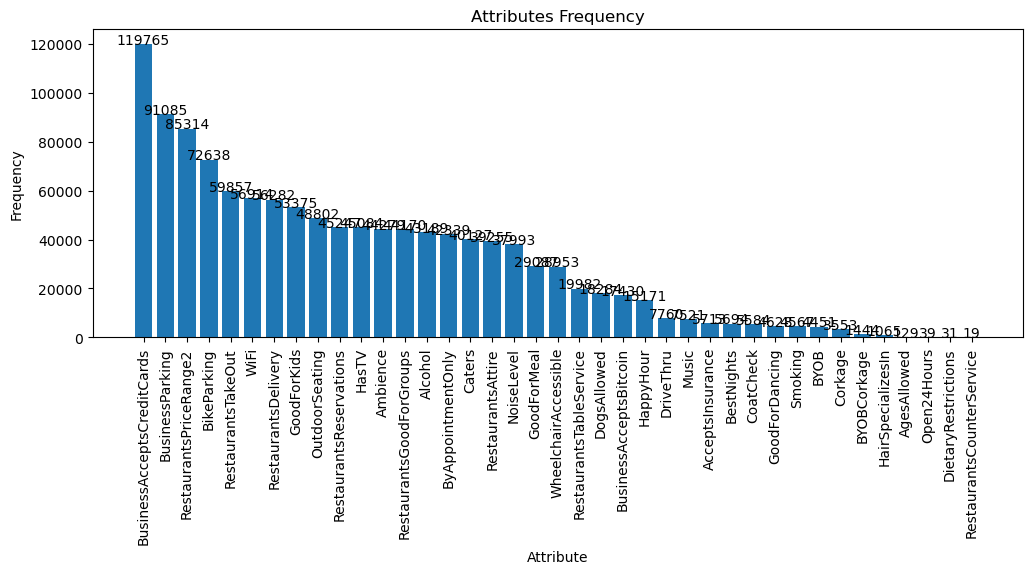

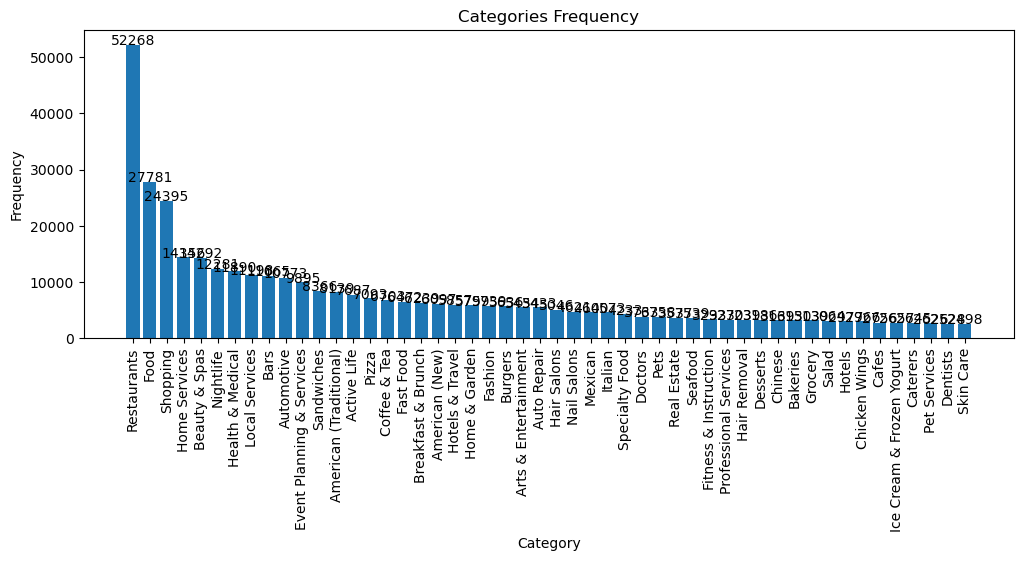

In [17]:
yelp_dataset_sets = {}

for fileType in yelp_dataset_fileType:
    yelp_dataset_sets[fileType] = set()
    yelp_attributes_collect = {}
    yelp_categories_collect = {}
    for data in yelp_dataset[fileType]:
        yelp_dataset_sets[fileType].update(set(data.keys()))
        if 'attributes' in data.keys() and data['attributes'] is not None:
            for k in data['attributes'].keys():
                yelp_attributes_collect.setdefault(k, 0)
                yelp_attributes_collect[k] += 1
        if 'categories' in data.keys() and data['categories'] is not None:
            words = data['categories'].split(', ')
            for word in words:
                yelp_categories_collect.setdefault(word, 0)
                yelp_categories_collect[word] += 1
    print(f"{fileType}: {yelp_dataset_sets[fileType]}")

    yelp_attributes_collect = {k:v for k,v in sorted(yelp_attributes_collect.items(), key=lambda x:x[1], reverse=True)}
    yelp_categories_collect = {k:v for k,v in sorted(yelp_categories_collect.items(), key=lambda x:x[1], reverse=True)[0:50]}
    bar(yelp_attributes_collect, "Attributes Frequency", "Attribute")
    bar(yelp_categories_collect, "Categories Frequency", "Category")


从以上代码可看出数据中每个样本共包含15个属性，现在我们如果要通过频繁模式挖掘算法对数据集进行挖掘，我们需要清楚哪些信息是需要的。

+ 本数据集基本为离散的商铺信息，故不适用序列挖掘
+ 本数据集的样本存在大量属性，且 `attributes` 和 `categories` 还存在细分属性，故适用项集挖掘

如果要挖掘项集，那么其中存在不少冗余信息：

+ `name`, `business_id`, `longitude`, `latitude` 是不必要的，因为他们并不是共有属性；
+ `postal_code` 是不必要的，因为一方面不是共有属性（细分到街道以及各州邮编格式不统一），一方面与城市、州的信息重复了；
+ `hours` 是不必要的，因为开放时间格式过于复杂，信息较多，难以与其他属性对齐；

剩下根据 `is_open` 属性筛选掉已关闭的商铺，仅保留仍在营业的商铺进行分析；

首先，我们先分析 `attributes` 具体有什么格式及其分布情况：

`attributes` 的不少属性可以视为：`{True, False, None}` 的三个选项，如“是否仅通过预约”这条属性。
对于这种情况，如果属性默认为真，可将未提及该属性的样本视为真，反之亦然。
对于 `attributes` 难以细分的其他种类，考虑进行剔除。

In [243]:
yelp_clean_data = []

available_attr = ['ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'BikeParking', 'CoatCheck', 'RestaurantsTakeOut', 'RestaurantsDelivery', 'Caters', 'WheelchairAccessible', 'HappyHour', 'OutdoorSeating', 'HasTV', 'RestaurantsReservations', 'DogsAllowed', 'GoodForKids', 'RestaurantsTableService', 'RestaurantsGoodForGroups', 'DriveThru', 'BusinessAcceptsBitcoin', 'GoodForDancing', 'AcceptsInsurance', 'BYOB', 'Corkage', 'Open24Hours', 'RestaurantsCounterService', ]
special_attr = ['RestaurantsPriceRange2', 'WiFi', 'Alcohol', 'RestaurantsAttire', 'Smoking']

stat_collect = set()
star_collect = set()
attr_collect = set()
cate_collect = set()

# RestaurantsPriceRange2: {'None', '4', '2', '1', '3'}
# WiFi: {"'paid'", 'None', "'no'", "u'free'", "'free'", "u'no'", "u'paid'"}
# Alcohol: {"u'beer_and_wine'", 'None', "u'full_bar'", "u'none'", "'full_bar'", "'none'", "'beer_and_wine'"}
# RestaurantsAttire: {'None', "'dressy'", "'formal'", "u'formal'", "u'casual'", "u'dressy'", "'casual'"}
# Smoking: {'None', "'no'", "u'yes'", "u'outdoor'", "'outdoor'", "u'no'"}

for fileType in yelp_dataset_fileType:
    for data in yelp_dataset[fileType]:
        if data['is_open'] == 0:
            continue
        data_array = [data['city'], data['state'], f"stars:{data['stars']}"]
        stat_collect.add(data['state'])
        star_collect.add(f"stars:{data['stars']}")
        if 'attributes' in data.keys() and data['attributes'] is not None:
            for attr in available_attr:
                if attr in data['attributes'].keys() and data['attributes'][attr] == 'True':
                    data_array.append(f"{attr}")
                    attr_collect.add(f"{attr}")
            for attr in special_attr:
                if attr in data['attributes'].keys() and data['attributes'][attr] != 'None':
                    if attr == 'RestaurantsPriceRange2':
                        data_array.append(f"{attr}:{data['attributes'][attr]}")
                        attr_collect.add(f"{attr}:{data['attributes'][attr]}")
                    elif attr == 'WiFi':
                        if data['attributes'][attr] in ["'paid'", "u'paid'"]:
                            v = 'paid'
                        elif data['attributes'][attr] in ["'free'", "u'free'"]:
                            v = 'free'
                        else:
                            continue
                        data_array.append(f"{attr}:{v}")
                        attr_collect.add(f"{attr}:{v}")
                    elif attr == 'Alcohol':
                        if data['attributes'][attr] in ["'beer_and_wine'", "u'beer_and_wine'"]:
                            v = 'beer_and_wine'
                        elif data['attributes'][attr] in ["'full_bar'", "u'full_bar'"]:
                            v = 'full_bar'
                        else:
                            continue
                        data_array.append(f"{attr}:{v}")
                        attr_collect.add(f"{attr}:{v}")
                    elif attr == 'RestaurantsAttire':
                        if data['attributes'][attr] in ["'dressy'", "u'dressy'"]:
                            v = 'dressy'
                        elif data['attributes'][attr] in ["'formal'", "u'formal'"]:
                            v = 'formal'
                        elif data['attributes'][attr] in ["'casual'", "u'casual'"]:
                            v = 'casual'
                        else:
                            continue
                        data_array.append(f"{attr}:{v}")
                        attr_collect.add(f"{attr}:{v}")
                    elif attr == 'Smoking':
                        if data['attributes'][attr] in ["'yes'", "u'yes'"]:
                            v = 'yes'
                        elif data['attributes'][attr] in ["'no'", "u'no'"]:
                            v = 'no'
                        elif data['attributes'][attr] in ["'outdoor'", "u'outdoor'"]:
                            v = 'outdoor'
                        else:
                            continue
                        data_array.append(f"{attr}:{v}")
                        attr_collect.add(f"{attr}:{v}")

        if 'categories' in data.keys() and data['categories'] is not None:
            words = data['categories'].split(', ')
            data_array.extend(words)
            cate_collect.update(words)
        yelp_clean_data.append(data_array)

df = pd.DataFrame(yelp_clean_data)
df.to_csv(f'./dataset/yelp_dataset/yelp_clean_business.csv')

### 1.2 频繁模式挖掘

直接进行Apriori挖掘，最低支持度为0.2：

In [244]:
# 转换数据集为布尔值DataFrame
df = get_bool_df(yelp_clean_data)

# 使用Apriori算法找出频繁项集
apriori_df = fp_search(apriori, df, 0.2, min_length=2)

print(apriori_df.head(10))

     support                                                       itemsets
13  0.318710  (BusinessAcceptsCreditCards, BikeParking)                    
17  0.267682  (RestaurantsTakeOut, BusinessAcceptsCreditCards)             
16  0.262502  (RestaurantsPriceRange2:2, BusinessAcceptsCreditCards)       
19  0.255451  (Restaurants, RestaurantsTakeOut)                            
15  0.240981  (Restaurants, BusinessAcceptsCreditCards)                    
21  0.221374  (Restaurants, RestaurantsTakeOut, BusinessAcceptsCreditCards)
14  0.214515  (BusinessAcceptsCreditCards, GoodForKids)                    
18  0.202618  (WiFi:free, BusinessAcceptsCreditCards)                      
20  0.201223  (RestaurantsTakeOut, RestaurantsDelivery)                    


显而易见的是，含 `BusinessAcceptsCreditCards` 的项集占有较高的支持度，这是因为 `BusinessAcceptsCreditCards` 本身就是1-项集中的最频繁项集

接下来我们找闭频繁项集和最大频繁项集：

In [171]:
# 逐步增加max_len的值，找出所有的闭频繁项集
for l in range(3, len(df)):
    fpg_df = fp_search(fpgrowth, df, min_support=0.03, max_length=l, min_length=l)

    if len(fpg_df) == 0:
        break

    print(f"闭频繁项集长度为 {l}:")
    print(fpg_df.iloc[0], '\n')

闭频繁项集长度为 3:
support     0.221374                                                     
itemsets    (Restaurants, RestaurantsTakeOut, BusinessAcceptsCreditCards)
Name: 102, dtype: object 

闭频繁项集长度为 4:
support     0.172843                                                                               
itemsets    (Restaurants, RestaurantsTakeOut, BusinessAcceptsCreditCards, RestaurantsAttire:casual)
Name: 1531, dtype: object 

闭频繁项集长度为 5:
support     0.152584                                                                                            
itemsets    (RestaurantsTakeOut, BusinessAcceptsCreditCards, RestaurantsAttire:casual, Restaurants, GoodForKids)
Name: 2476, dtype: object 

闭频繁项集长度为 6:
support     0.131397                                                                                                                      
itemsets    (RestaurantsTakeOut, RestaurantsGoodForGroups, BusinessAcceptsCreditCards, RestaurantsAttire:casual, Restaurants, GoodForKids)
Name: 3190, dtype

接下来根据标签划分，寻找一些特殊的匹配模式：

+ 仅 `categories` 模式

In [ ]:
df_categories = []

for fileType in yelp_dataset_fileType:
    for data in yelp_dataset[fileType]:
        if data['is_open'] == 0:
            continue
        if 'categories' in data.keys() and data['categories'] is not None:
            words = data['categories'].split(', ')
            df_categories.append(words)

df_categories = get_bool_df(df_categories)

In [ ]:
fp_categories = fp_search(apriori, df_categories, 0.01, min_length=2, max_length=2)

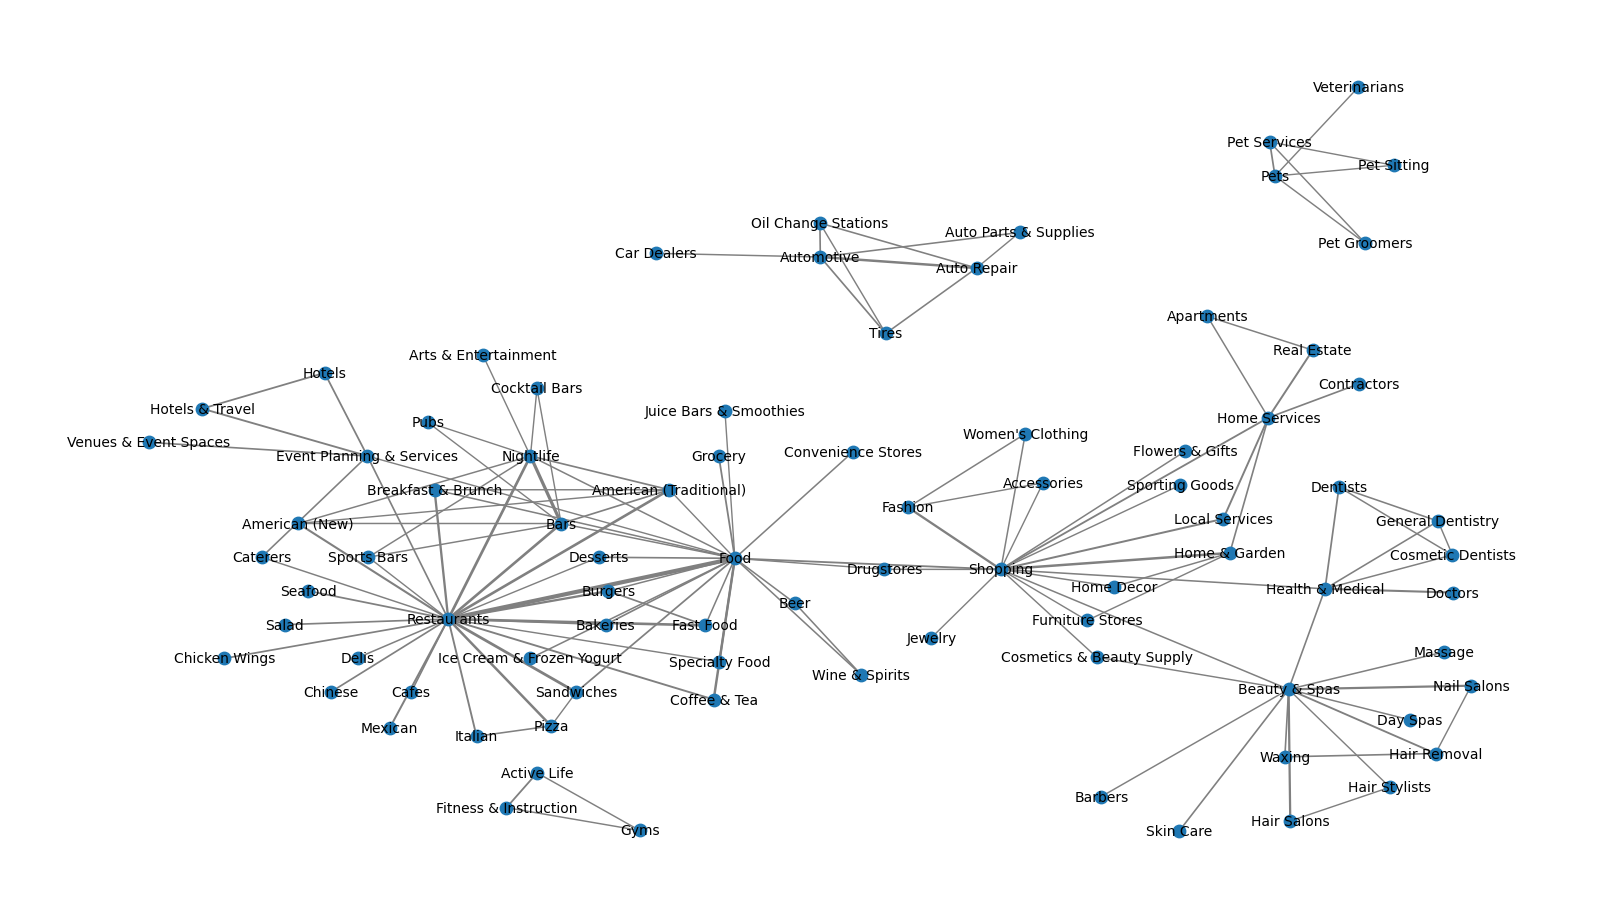

In [236]:
net(fp_categories, 'fdp')

可见通过挖掘2-项集可大致得到不同领域之间的关系。
围绕Restaurant和Food之间存在着各式菜系餐厅、酒吧，以及密切相关的酒店，可见酒店与餐饮业联系密切；
围绕Shopping、Beauty-Spas和Health & Medical形成三个密切关联的子网络，可见主要是为女性消费者提供服务的；
健身房、汽车行业和宠物行业由于其专业性而各自形成独立的小网络；

+ 仅 `attributes` 模式

In [240]:
df_attributes = df[list(attr_collect)]
fp_attributes = fp_search(fpgrowth, df_attributes, 0.1, min_length=2)

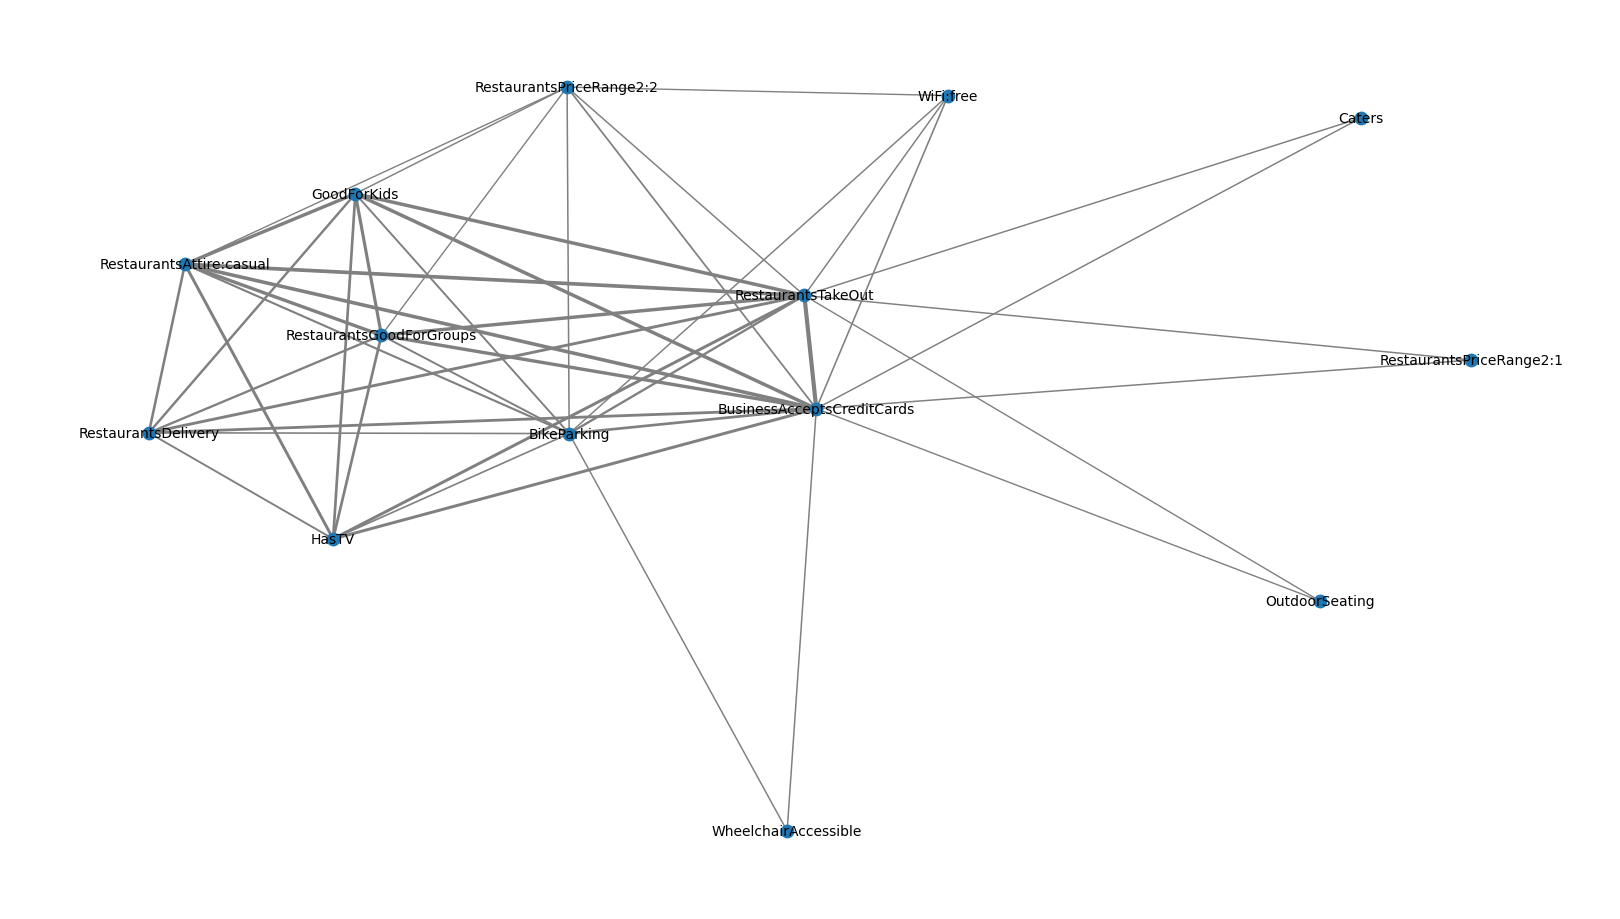

In [241]:
net(fp_attributes, "sfdp")

标签之间的耦合十分严重，将支持度设为0.1后可见较为清楚的网络结构；
网络中，无障碍（WheelchairAccessible）、户外就餐、饮食提供服务等标签为辅助性质；
无障碍服务仅与允许信用卡消费和自行车停车场高相关，可能是其他服务不便于提供给残疾人使用；
有意思的是，RestaurantPriceRange中，
1级（消费水平较低）的服务仅与外带食物、允许信用卡消费关联度高，
而2级（消费水平较高）的服务除此之外，还有免费WiFi、儿童友好、团体友好、自行车停车场、着装要求（日常）等高关联度标签；

+ `stars-attr/cate` 联合模式（模式中至少有一个元素属于星级划分）

In [260]:
df_star_attr_cate = df[list(attr_collect) + list(cate_collect) + list(star_collect)]
fp_star_attr_cate = fp_search(fpgrowth, df_star_attr_cate, 0.02, min_length=2, max_length=4)
# fp_star_attr_cate = fp_star_attr_cate[fp_star_attr_cate['itemsets'].apply(lambda x: any(item in star_collect for item in x))]

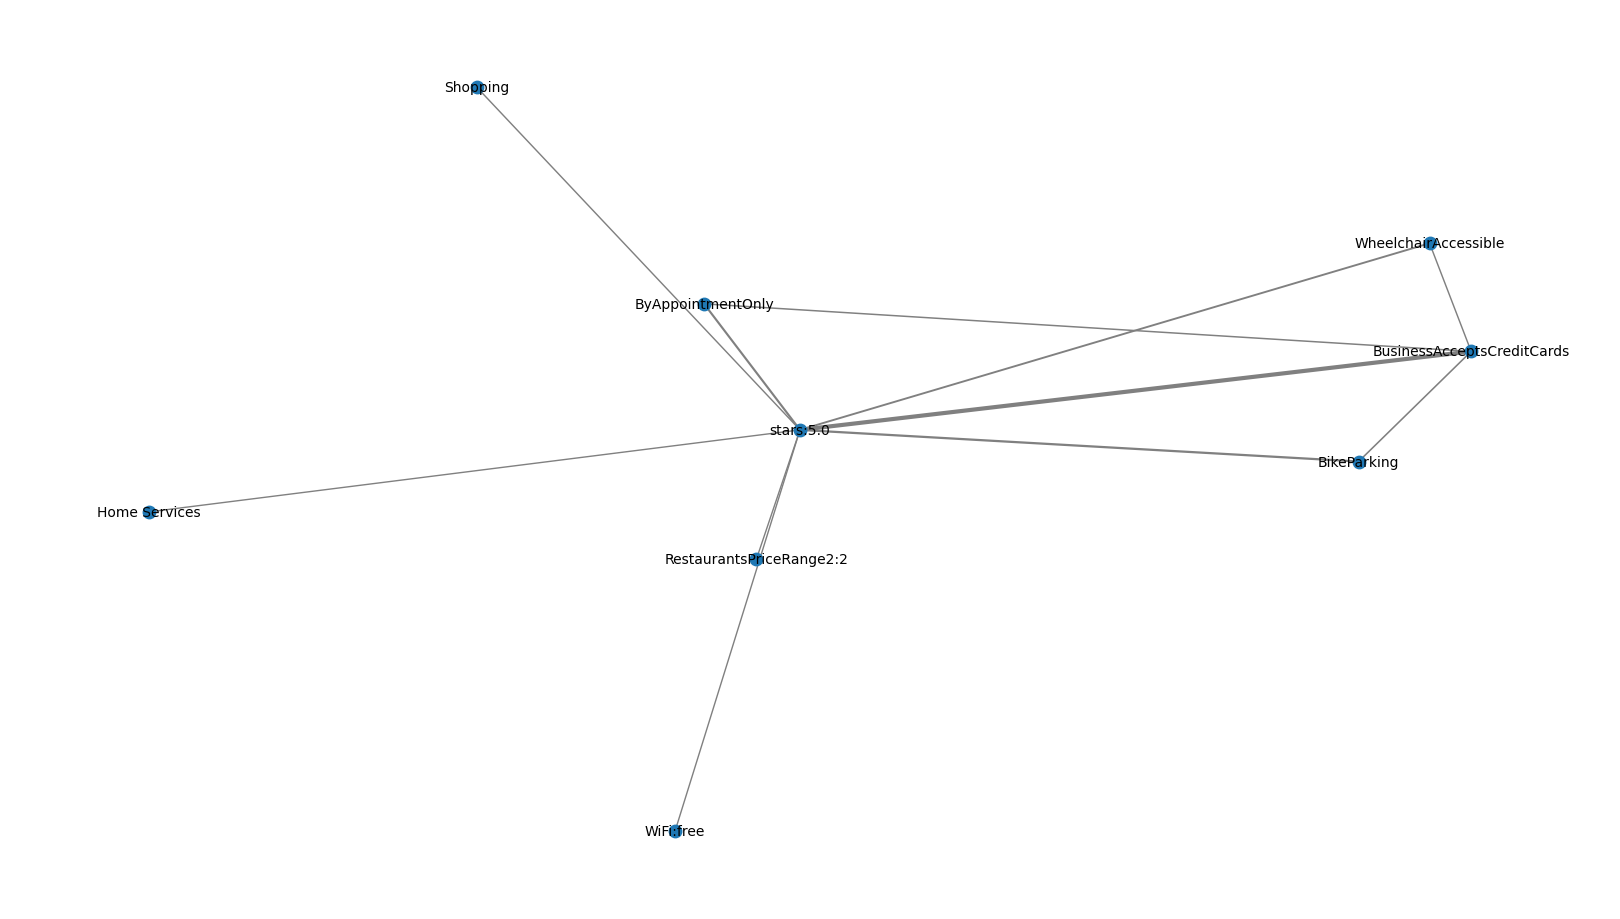

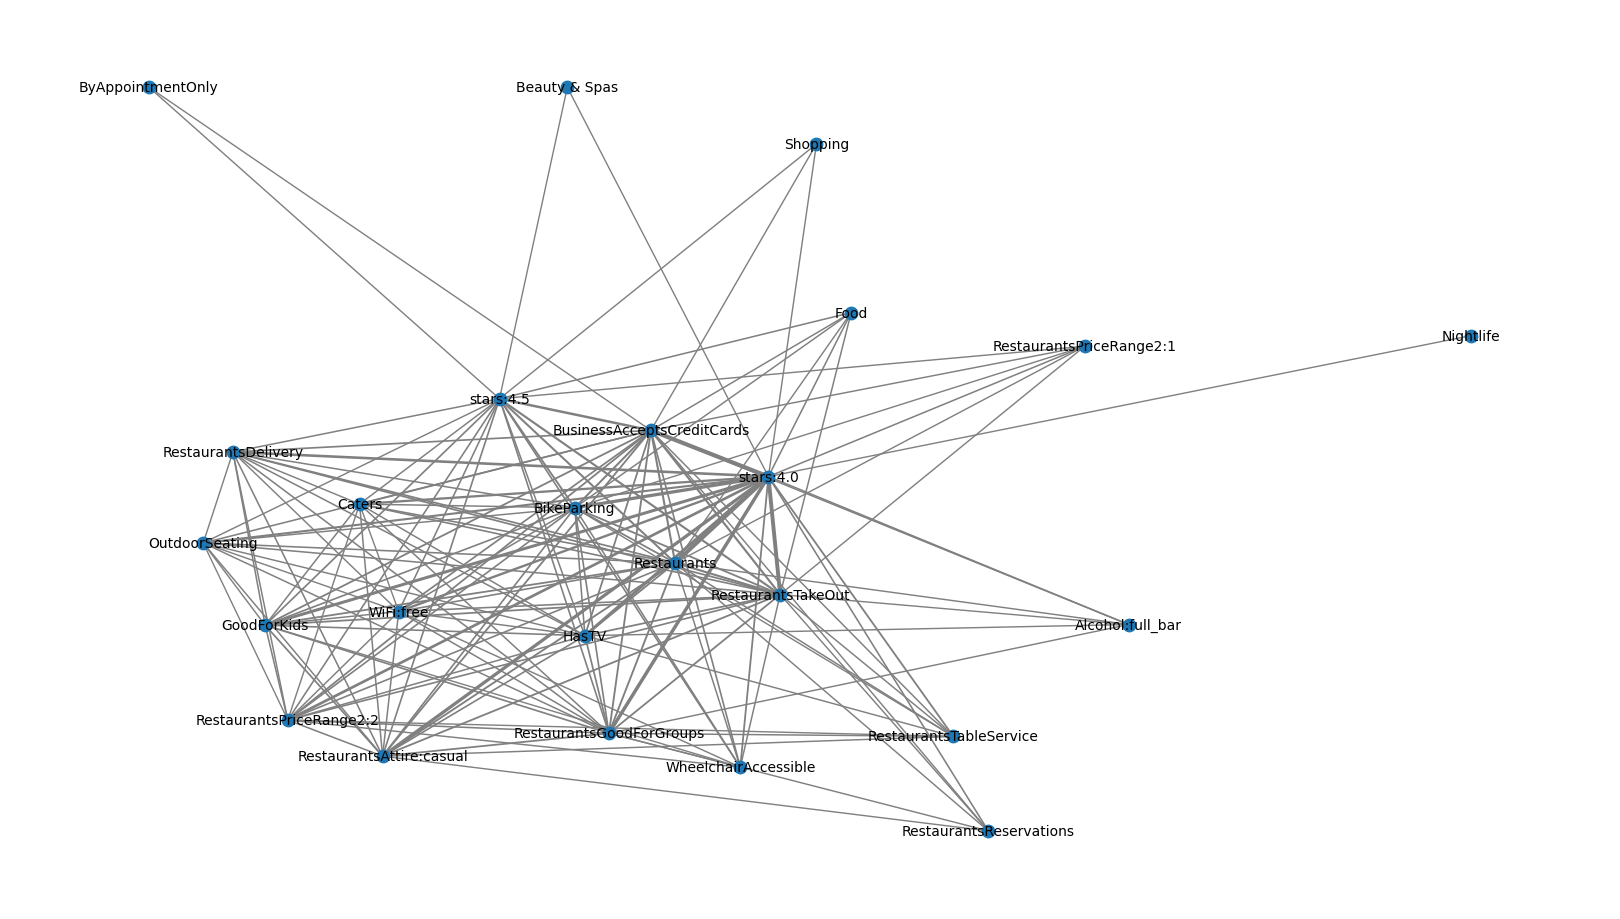

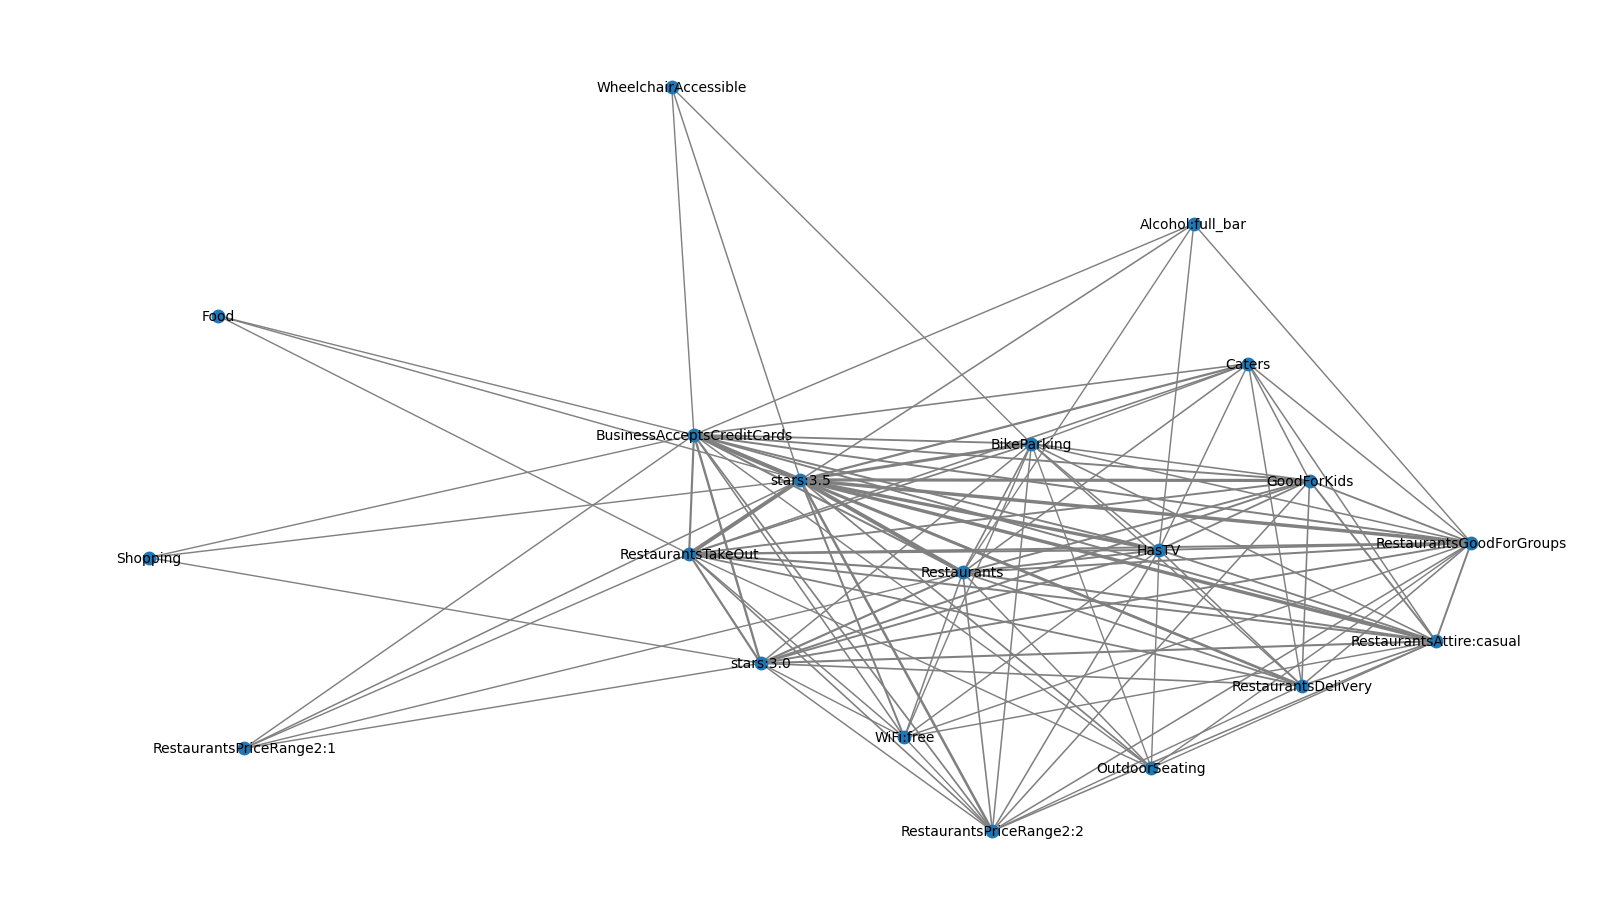

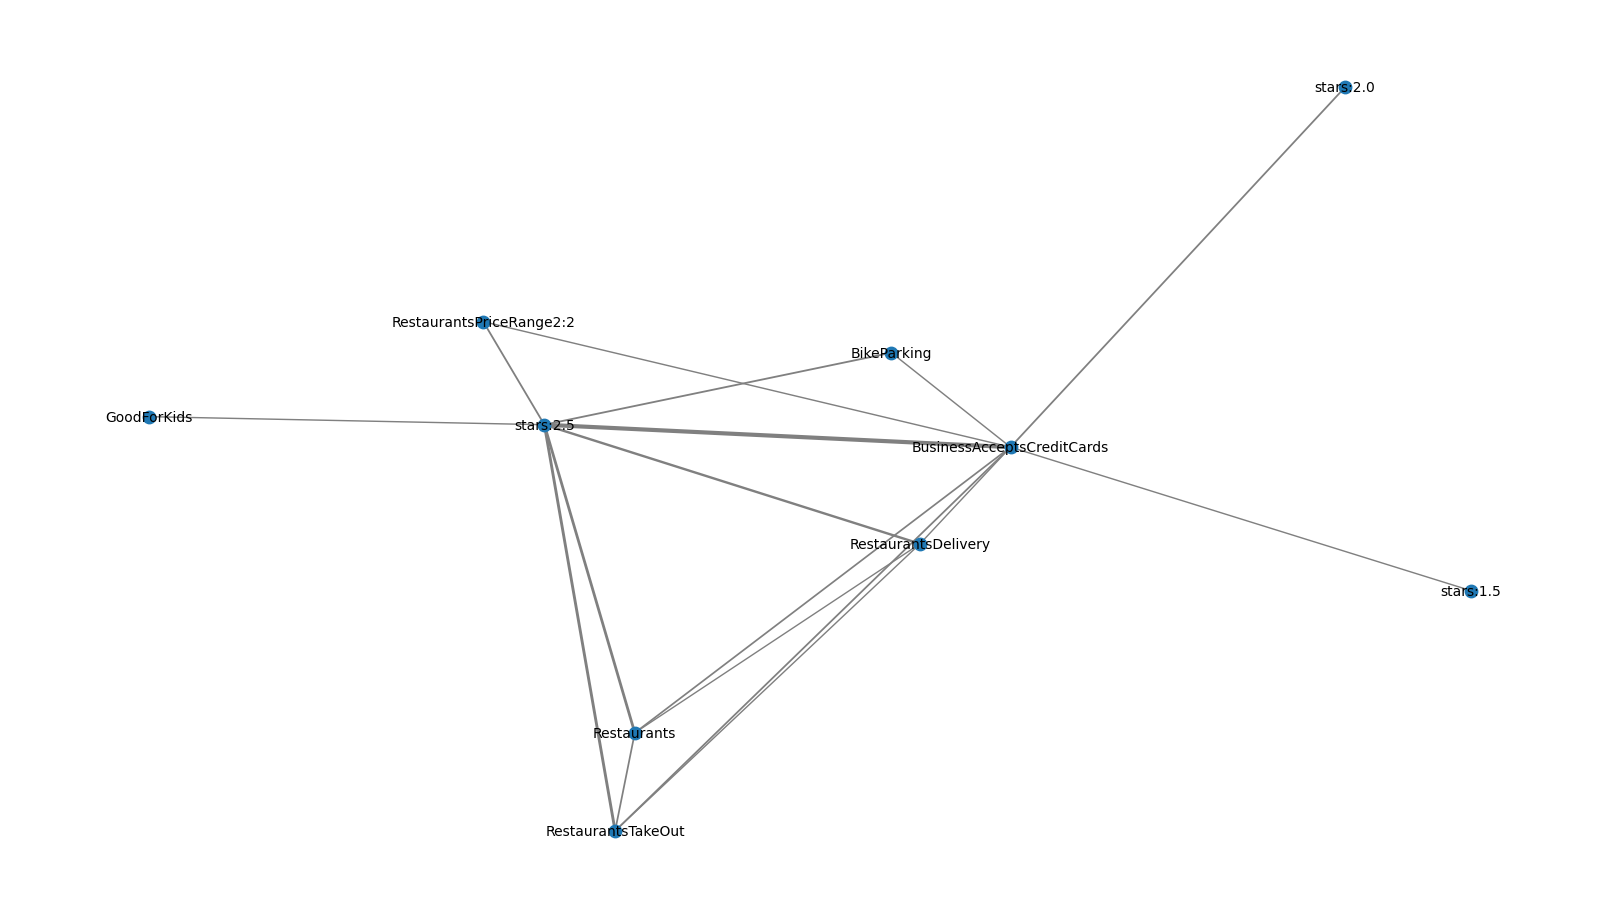

In [259]:
net(fp_star_attr_cate[fp_star_attr_cate['itemsets'].apply(lambda x: 'stars:5.0' in x)])
net(fp_star_attr_cate[fp_star_attr_cate['itemsets'].apply(lambda x: any(item in ['stars:4.0', 'stars:4.5'] for item in x))])
net(fp_star_attr_cate[fp_star_attr_cate['itemsets'].apply(lambda x: any(item in ['stars:3.0', 'stars:3.5'] for item in x))])
net(fp_star_attr_cate[fp_star_attr_cate['itemsets'].apply(lambda x: any(item in ['stars:1.0', 'stars:1.5', 'stars:2.0', 'stars:2.5'] for item in x))])

1. 五星商铺一般与仅预约、无障碍、自行车停车场、住家服务、免费WiFi、价格档位2紧密关联。可以看出，五星商铺一般会提供更为细节的、定制化的服务，同时保持一个较好的性价比；
2. 四星商铺关联度高的标签很多，营业类型主要为餐厅，其中最主要的是食物外带和团体友好（团餐）这两个标签；
3. 三星商铺差别不大，不过这是所有评级里唯一和价格档位1相关度高的一档，可以理解为大众食堂，服务不算好所以上不去评分，但是毕竟价格在这，也不会太差；
4. 低星商铺中有儿童友好标签，可能写评价的不是儿童而是被吵到的大人所以拉低了评分，另外就是低星商铺提供的服务类别太少；

+ `state-attr/cate` 联合模式（模式中至少有一个元素属于州）

In [267]:
df_stat_attr_cate = df[list(attr_collect) + list(cate_collect) + list(stat_collect)]
fp_stat_attr_cate = fp_search(fpgrowth, df_stat_attr_cate, 0.01, min_length=2, max_length=2)
fp_stat_attr_cate = fp_stat_attr_cate[fp_stat_attr_cate['itemsets'].apply(lambda x: any(item in stat_collect for item in x))]

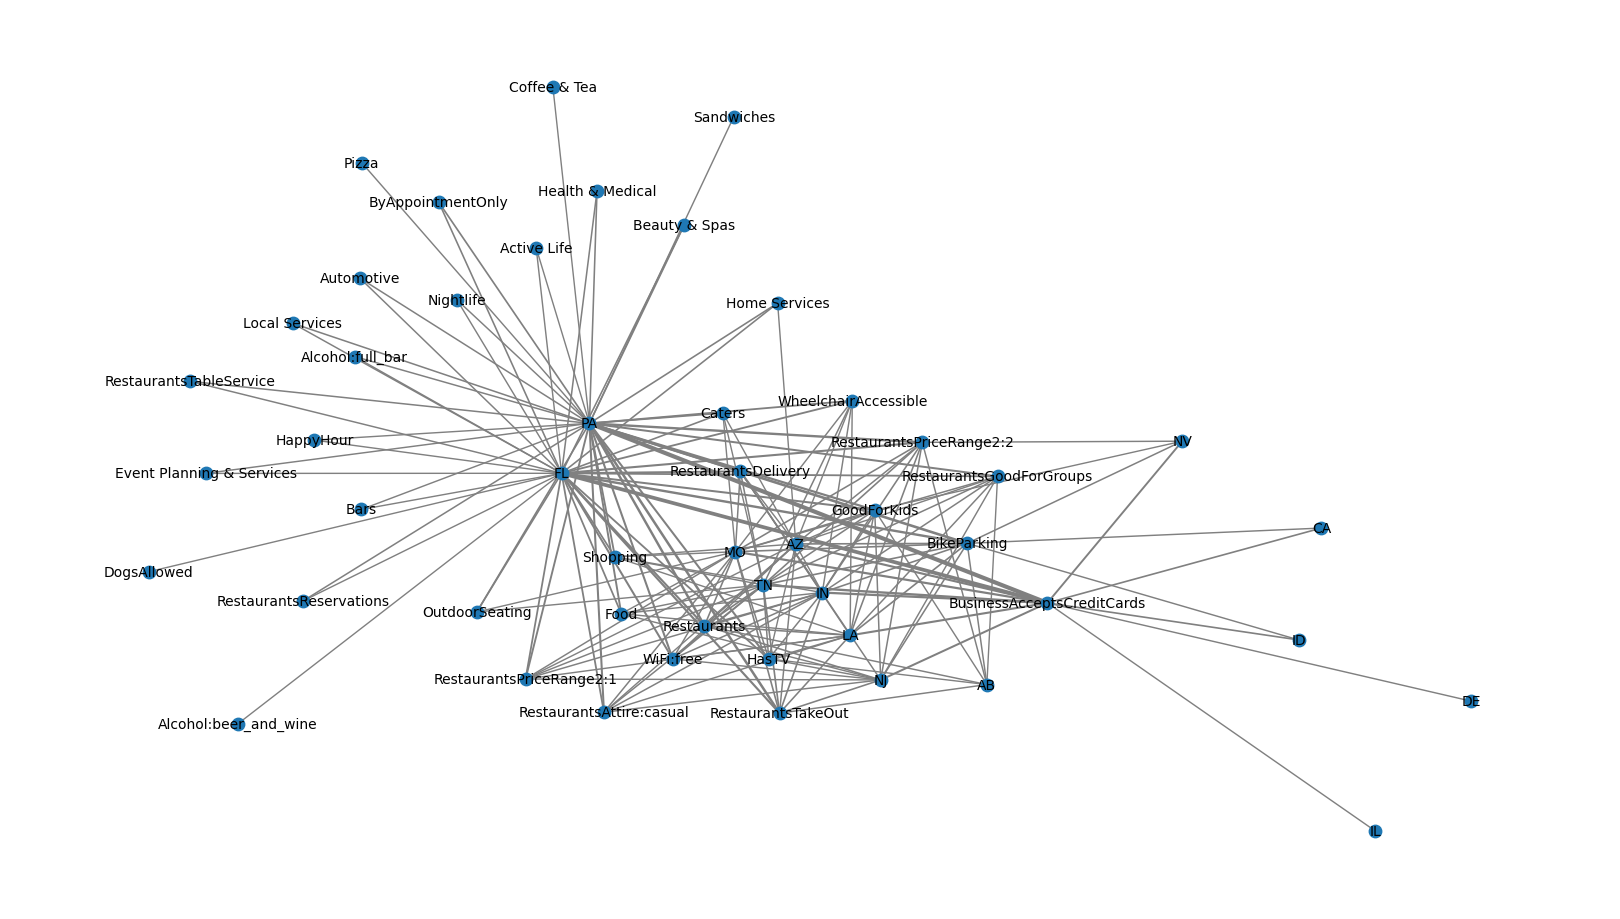

In [268]:
net(fp_stat_attr_cate)

这个模式类别可以看出，YELP公司的主要商户集中在宾夕法尼亚州、佛罗里达州、密苏里州、加利福尼亚州等地区；

## 2. Amazon product co-purchasing network metadata
### 2.1 数据获取与预处理

这些数据是通过抓取亚马逊网站收集的，包含548552种不同产品（书籍、音乐CD、DVD和VHS录像带）的产品元数据和评论信息。

对于每种产品，都提供以下信息：

+ 标题
+ Salesrank
+ 类似产品列表（与当前产品共同购买）
+ 详细的产品分类
+ 产品评论：时间、客户、评分、投票数、认为评论有帮助的人数

数据收集于2006年夏季。

这是一个很典型的商品数据集，可以分析什么样的标签会同时出现。
这个数据集可以尝试去除那些过于频繁的1-项集来获取更有用的信息。

In [7]:
import random
import re
import pbar

amazon_dataset_path = "./dataset/amazon-meta.txt"

merchants = []
tags_collect = set()

with pbar.PBar("Loading...", run_on_jupyter=True) as p:
    with open(amazon_dataset_path, 'r', encoding='utf-8') as file:
        length = len(file.readlines())
    with open(amazon_dataset_path, 'r', encoding='utf-8') as file:
        reading = False
        temp_set = set()
        for line in p.pbar_iter(file.readlines(), length, "Read Lines"):
            if re.match(r'^[\s]+\|', line):
                if not reading:
                    reading = True
                info = re.sub(r'\[[^\[\]]*\]', '', line)
                info = re.sub(r'^[\W]*(?=[\w])', '', info)
                info = info.replace('\n', '')
                info = [f for f in info.split('|') if re.match(r'^[\w].*[\w]', f)]
                temp_set.update(info)
            elif reading:
                reading = False
                if random.choice([True, False]):
                    merchants.append(list(temp_set))
                    tags_collect.update(temp_set)
                temp_set.clear()

df_amazon = pd.DataFrame(merchants)
df_amazon.to_csv(f'./dataset/amazon-data.csv')

Process Done.


### 2.2 频繁模式挖掘

Books、Subjects、General、Music是最频繁的1-项集，尝试逐层剔除；

In [8]:
# 转换数据集为布尔值DataFrame
df_amazon = get_bool_df(merchants)

In [11]:
df_amazon = df_amazon.drop(columns=['Books', 'Subjects', 'General', 'Music'])

In [13]:
fp_amazon = fp_search(fpgrowth, df_amazon, min_support=0.02, min_length=2)

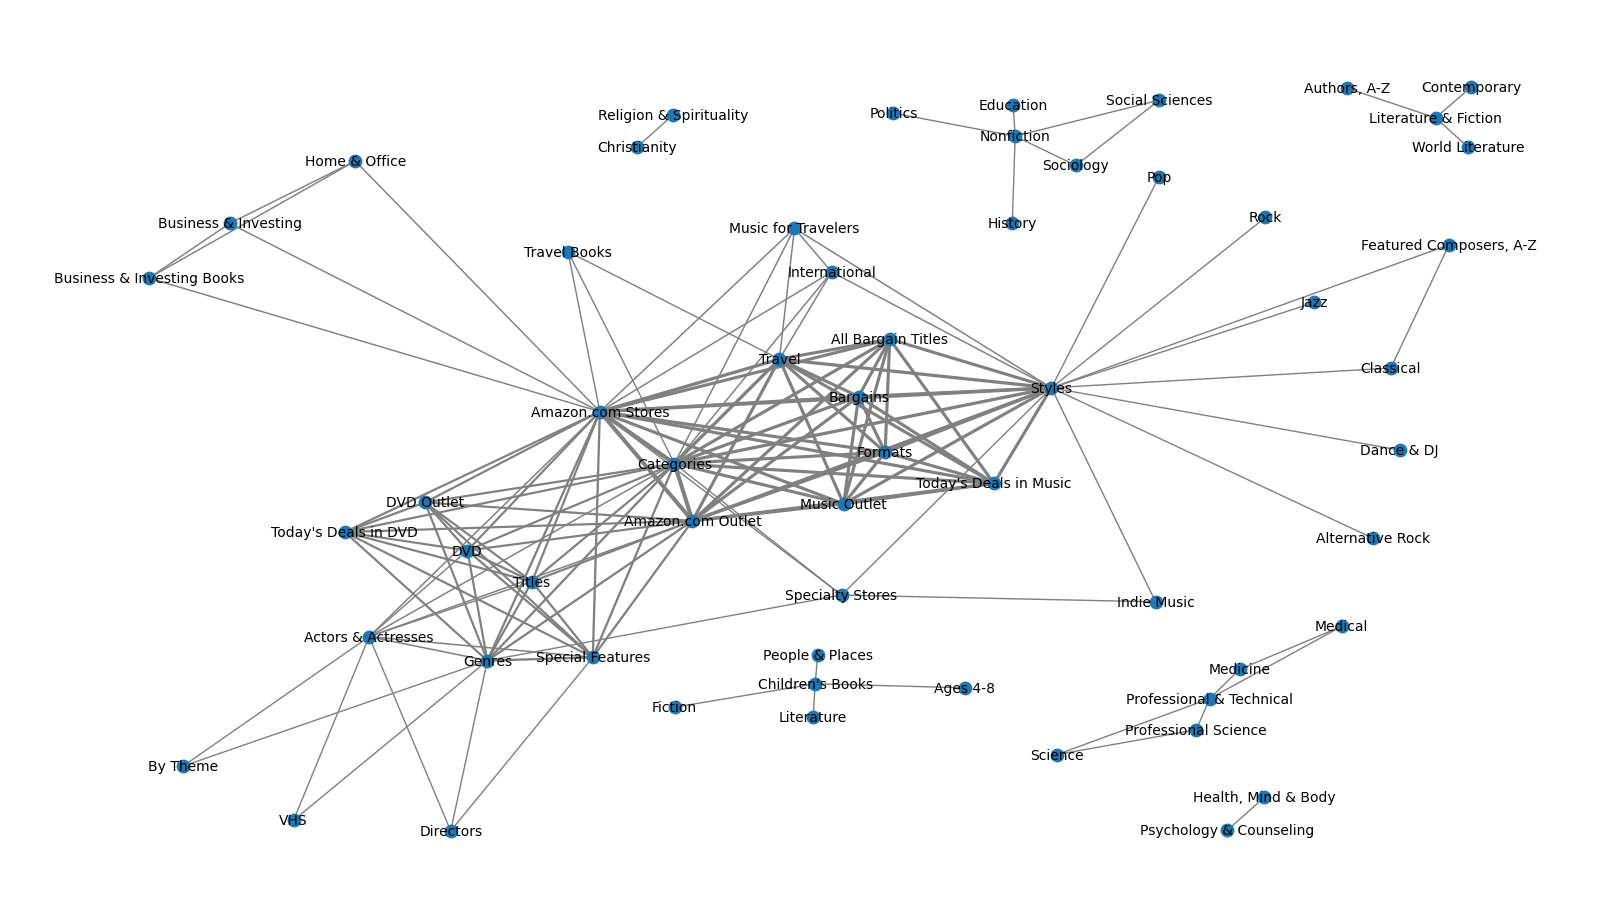

In [14]:
net(fp_amazon)

剔除主要的4个频繁1-项集后，得到了一张十分清晰的商品标签关系网络。

+ 主网络围绕亚马逊在线、亚马逊奥特莱斯、旅行、音乐风格等十分主流的标签展开；
+ 奇幻文学、儿童读物、文学等标签构成了一个独立小网络；
+ 科技、医疗、专业技术等标签构成了一个独立小网络；
+ 健康（可以理解为养生）、心理咨询构成了一个独立小网络；
+ 宗教类书籍构成了一个独立小网络；